In [4]:
import copy
import json
import numbers
import os
import os.path as osp
from json import JSONDecodeError
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.interpolate
import seaborn as sns

from marlpo.utils.plot import *

# Step 1: Processing training results

In [2]:
# 目录名 -> 环境正式名称
env_mapping = {
    'inter': 'Intersection',
    'round': 'Roundabout',
}

In [3]:
def parse_trials_in_dir(root):
    """
    Read and form data into a dataframe
    root:
        trial_0/
            progress.csv
        ...
    """
    print(f'Processing env <{osp.split(root)[-1]}>...')
    df = []
    # 获得root下的所有为目录的路径
    paths = [osp.join(root, p) for p in os.listdir(root) if osp.isdir(osp.join(root, p))]
    for pi, p in enumerate(tqdm(paths)):
        # print(f"Finish {pi + 1}/{len(paths)} trials.")
        try:
            ret = pd.read_csv(osp.join(p, 'progress.csv')) # <~~ Modified Here!
            # *** 加入文件名称，便于后续区分 ***
            ret['file_name'] = osp.split(p)[-1]

        except (FileNotFoundError, JSONDecodeError):
            print("Path {} not found. Continue.".format(p))
            continue
        if ret is not None:
            df.append(ret)
    if not df:
        print("No Data Found!")
        return None
    df = pd.concat(df)

    return df


def parse_one_algo(path):
    """
    path: 
        inter/
        round/
    """
    df = []
    env_paths = [osp.join(path, p) for p in os.listdir(path) if osp.isdir(osp.join(path, p))]
    for p in env_paths:
        _df = parse_trials_in_dir(p)
        # 加入环境/场景名称
        env_name = env_mapping[osp.split(p)[-1]]
        _df['env'] = env_name
        df.append(_df)

    df = pd.concat(df)
    return df

In [4]:
def smooth(data, num_points=200, interpolate_x="timesteps_total", interpolate_y=None, y_span=1, splitter="file_name"):
    data = data.copy()
    if num_points <= 0:
        return data
    trial_list = [j for i, j in data.groupby(splitter)] # i: file_name values, j: df
    num_points_ = int(max(len(df) for df in trial_list))
    print("Found {} points, draw {} points.".format(num_points_, num_points))
    num_points = min(num_points, num_points_)
    range_min = min(df[interpolate_x].min() for df in trial_list) # 1024
    range_max = max(df[interpolate_x].max() for df in trial_list) # 2000896
    interpolate_range = np.linspace(range_min, range_max, num_points)
    keys = data.keys() # columns
    new_trial_list = []
    for df in trial_list:
        mask = np.logical_and(df[interpolate_x].min() < interpolate_range, interpolate_range < df[interpolate_x].max())
        mask_rang = interpolate_range[mask]
        if len(df) > 1:
            new_df = {}
            df = df.reset_index(drop=True)
            for k in keys:
                if isinstance(df[k][0], numbers.Number):
                    try:
                        new_df[k] = scipy.interpolate.interp1d(df[interpolate_x], df[k])(mask_rang)
                    except ValueError:
                        continue
                elif isinstance(df[k][0], list):
                    continue
                else:
                    new_df[k] = df[k].unique()[0]
            new_trial_list.append(pd.DataFrame(new_df))
        else:
            new_trial_list.append(df)
    return pd.concat(new_trial_list, ignore_index=True)


处理原始训练`progress.csv`然后分别保存中间结果:

### IPPO

In [12]:
algo_path = 'eval_checkpoints/ippo'
algo_name = 'IPPO'
new_path = 'progress_ippo'

df = parse_one_algo(algo_path)
new_df = smooth(df)
new_df["algo"] = algo_name
new_df.to_csv("{}.csv".format(new_path))
# del df
# del new_df
print("Finished ", algo_name)

Processing env <inter>...


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 14.03it/s]


Processing env <round>...


100%|██████████| 8/8 [00:00<00:00, 14.36it/s]


Found 1954 points, draw 200 points.
Finished  IPPO


### CCPPO Concat

In [14]:
algo_path = 'eval_checkpoints/ccppo-concat'
algo_name = 'MAPPO'
new_path = 'progress_mappo'

df = parse_one_algo(algo_path)
new_df = smooth(df)
new_df["algo"] = algo_name
new_df.to_csv("{}.csv".format(new_path))
# del df
# del new_df
print("Finished", algo_name)

Processing env <inter>...


100%|██████████| 8/8 [00:00<00:00, 13.59it/s]


Processing env <round>...


100%|██████████| 8/8 [00:00<00:00, 14.35it/s]


Found 1954 points, draw 200 points.
Finished MAPPO


### CCPPO MF

In [13]:
algo_path = 'eval_checkpoints/ccppo-mf'
algo_name = 'MFPO'
new_path = 'progress_mfpo'

df = parse_one_algo(algo_path)
new_df = smooth(df)
new_df["algo"] = algo_name
new_df.to_csv("{}.csv".format(new_path))
print("Finished", algo_name)

Processing env <inter>...


100%|██████████| 8/8 [00:00<00:00, 14.07it/s]


Processing env <round>...


100%|██████████| 8/8 [00:00<00:00, 14.51it/s]


Found 1954 points, draw 200 points.
Finished MFPO


### CoPO

In [15]:
algo_path = 'eval_checkpoints/copo'
algo_name = 'CoPO'
new_path = 'progress_copo'

df = parse_one_algo(algo_path)
new_df = smooth(df)
new_df["algo"] = algo_name
new_df.to_csv("{}.csv".format(new_path))
print("Finished", algo_name)

Processing env <inter>...


100%|██████████| 8/8 [00:00<00:00, 12.29it/s]


Processing env <round>...


100%|██████████| 8/8 [00:00<00:00, 13.35it/s]


Found 1954 points, draw 200 points.
Finished CoPO


### SCPO

In [16]:
algo_path = 'eval_checkpoints/scpo'
algo_name = 'SCPO'
new_path = 'progress_scpo'

df = parse_one_algo(algo_path)
new_df = smooth(df)
new_df["algo"] = algo_name
new_df.to_csv("{}.csv".format(new_path))
print("Finished", algo_name)

Processing env <inter>...


100%|██████████| 8/8 [00:00<00:00, 13.56it/s]


Processing env <round>...


100%|██████████| 8/8 [00:00<00:00, 13.63it/s]


Found 1954 points, draw 200 points.
Finished SCPO


In [17]:
new_df.columns

Index(['episode_reward_max', 'episode_reward_min', 'episode_reward_mean',
       'episode_len_mean', 'episodes_this_iter', 'num_faulty_episodes',
       'num_healthy_workers', 'num_in_flight_async_reqs',
       'num_remote_worker_restarts', 'num_agent_steps_sampled',
       'num_agent_steps_trained', 'num_env_steps_sampled',
       'num_env_steps_trained', 'num_env_steps_sampled_this_iter',
       'num_env_steps_trained_this_iter',
       'num_env_steps_sampled_throughput_per_sec',
       'num_env_steps_trained_throughput_per_sec', 'timesteps_total',
       'num_steps_trained_this_iter', 'agent_timesteps_total', 'done',
       'episodes_total', 'training_iteration', 'trial_id', 'date', 'timestamp',
       'time_this_iter_s', 'time_total_s', 'pid', 'hostname', 'node_ip',
       'time_since_restore', 'iterations_since_restore', 'SuccessRate',
       'CrashRate', 'OutRate', 'MaxStepRate', 'RewardMean', 'StepMean',
       'DistanceMean', 'NeighboursMean', 'RewardsTotal', 'AgentsTotal',
   

# Step 2: Aggregate all results

分别读取中间结果，`concat`在一起并保存成一个`training_results.csv`文件

In [36]:
all_algo_names = ['ippo', 'mfpo', 'mappo', 'copo', 'scpo']
all_results = pd.concat([pd.read_csv(f'progress_{name}.csv') for name in all_algo_names]).reset_index()

In [30]:
all_results.env.unique()

array(['Intersection', 'Roundabout'], dtype=object)

/Users/jimmy/miniforge3/envs/marl/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


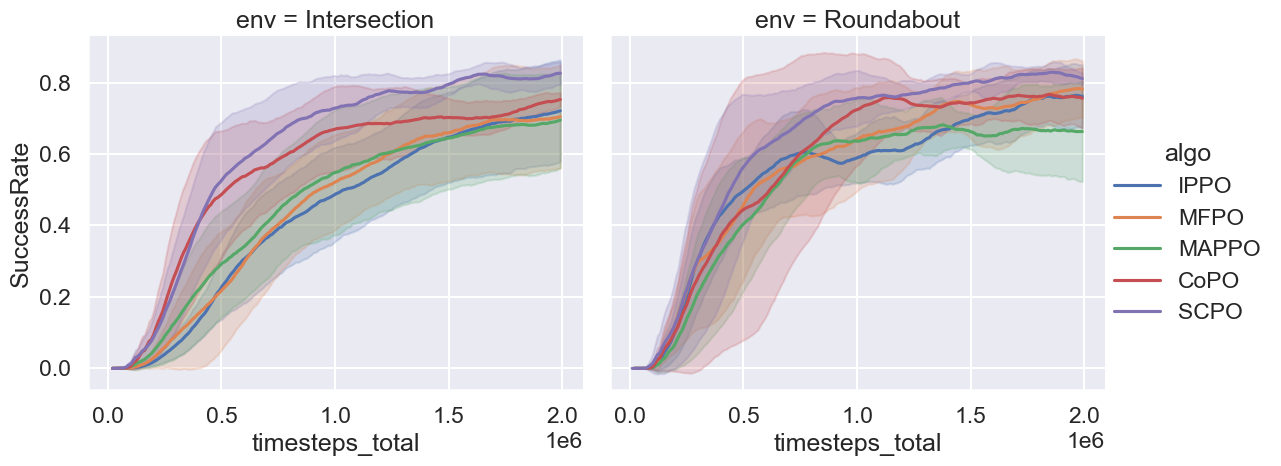

In [38]:
# Draw a little figure to see if data is processed properly.
sns.set("talk", "darkgrid")
ax = sns.relplot(
    x="timesteps_total",
    y="SuccessRate", 
    hue='algo',
    data=all_results.copy(),
    # ci="sd",
    errorbar='sd',
    kind="line",
    col="env",
    aspect=1.15,
)

In [39]:
all_results.to_csv('progress_all.csv')

# Step 3: Plot

In [4]:
data = pd.read_csv("progress_all.csv")

In [5]:
data.algo.unique()

array(['IPPO', 'MFPO', 'MAPPO', 'CoPO', 'SCPO'], dtype=object)

/Users/jimmy/miniforge3/envs/marl/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


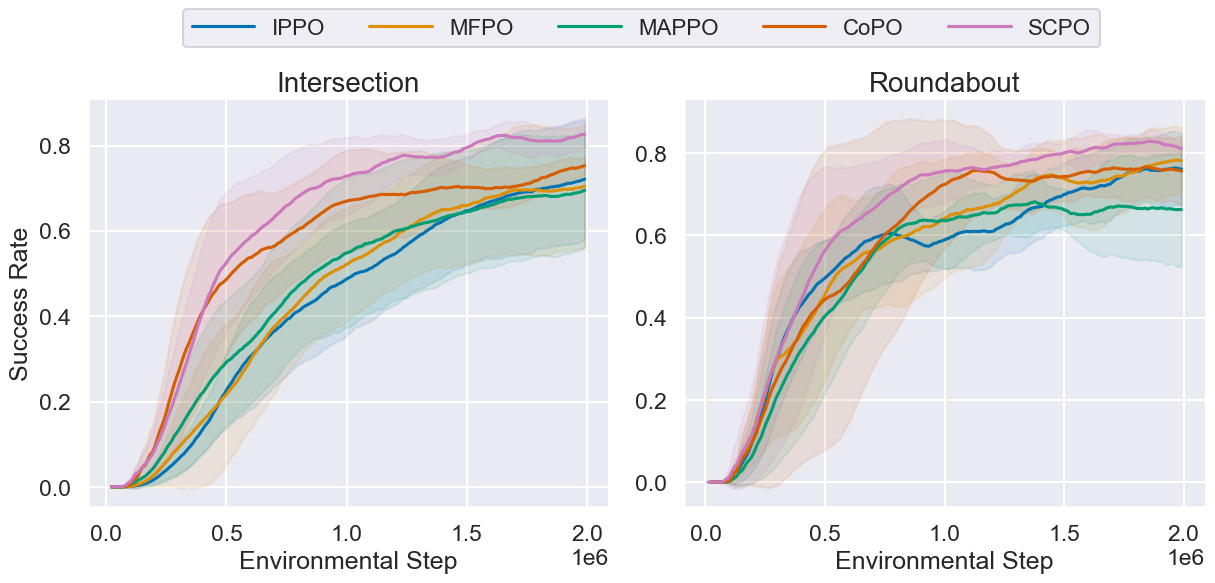

In [8]:
plot_df = data.copy()
x = "timesteps_total"
y = "SuccessRate"
y_label = 'Success Rate'

tmplist = []
for algo in ['IPPO', 'MFPO', 'MAPPO', 'CoPO', 'SCPO']:
    tmp = plot_df[plot_df.algo == algo]
#     tmp = tmp[tmp.timesteps_total < 100_0000]
    tmplist.append(tmp)
plot_df = pd.concat(tmplist)

c = sns.color_palette("colorblind")
sns.set("talk", "darkgrid")

ax = sns.relplot(
    x=x,
    y=y, 
    hue='algo',
#     palette=[c[0], c[2]],
    palette=list(c)[:len(plot_df.algo.unique())],
    data=plot_df,
    # ci="sd", # deprecated
    errorbar='sd',
#     legend=None,
    kind="line",
    col="env",
    facet_kws=dict(sharey=False, sharex=False),
#     linewidth=1,
#     height=5,
#     aspect=1.333,
#     facet_kws={"alpha": 0.1}
#     col_wrap=3,
    err_kws=dict(alpha=0.1),
    aspect=1.25,
#     linewidth=2,
#     legend=None
#     legend_out=False
#     facet_kws={"alpha": 0.2}
)

for axxx in ax.axes.flat:
    axxx.set_xlabel("Environmental Step")
ax.set_ylabels(y_label)

fontsize = 20
ax.set_titles(col_template = '{col_name}', size=fontsize)
for env, axxx in ax.axes_dict.items():
    axxx.ticklabel_format(style='sci', scilimits=(0,0), axis='x')

hs = ax.legend.legend_handles
ax.legend.set_visible(False)

# legend_ax = ax.fig.add_axes([1., 0.9, 0.1, 0.1])
plt.legend(
    handles=hs, 
    # title="Method", 
    # title_fontsize=fontsize, 
    loc='best',
    bbox_to_anchor=(0.82, 1.25), 
    frameon=True,
    ncol=5,
    fontsize=fontsize*0.8,
    labelspacing=0.8, 
    handlelength=2.8
)

plt.subplots_adjust(top=1)

plt.savefig('learning_curve.pdf', format='pdf', dpi=300, facecolor='#FFF', bbox_inches="tight")
plt.savefig('learning_curve.png', format='png', dpi=200, facecolor='#FFF', bbox_inches="tight")

# Ablation Study Learning Curves

> Only in Intersection scenario.
> 
> Produce **no** middle files

## 1 Study for various $\phi$

In [603]:
from marlpo.utils.plot import plot_sep_mean, plot_one_exp

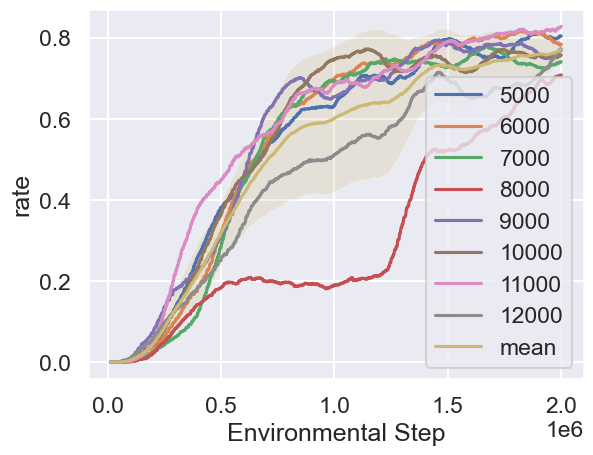

In [92]:
root1 = 'exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][phi]_coeff=0'

plot_sep_mean(root1, )

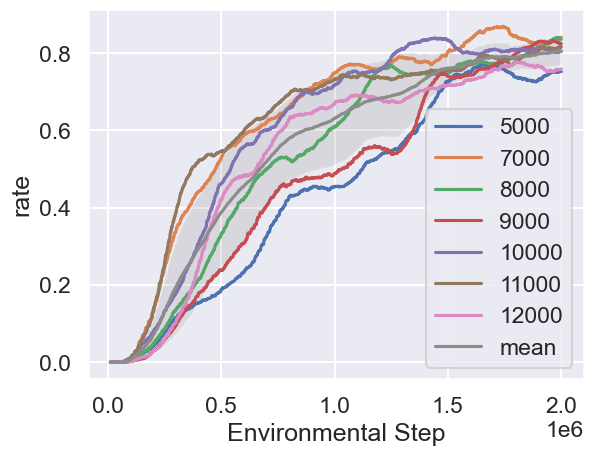

In [94]:
root2 = 'exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][phi]_coeff=0.5'
plot_sep_mean(root2, )

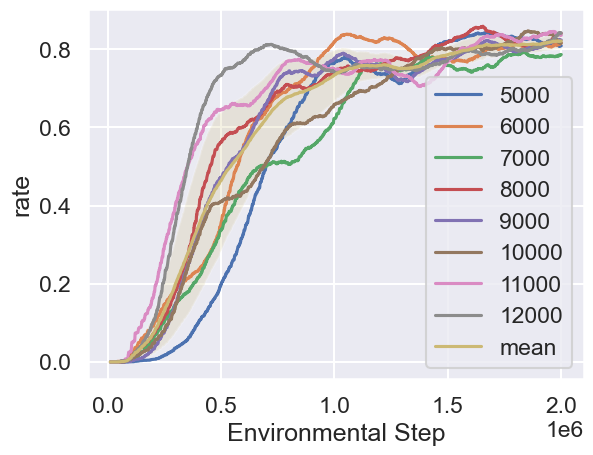

In [95]:
root3 = 'exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][phi]_coeff=1'
plot_sep_mean(root3, )

compare to scpo:

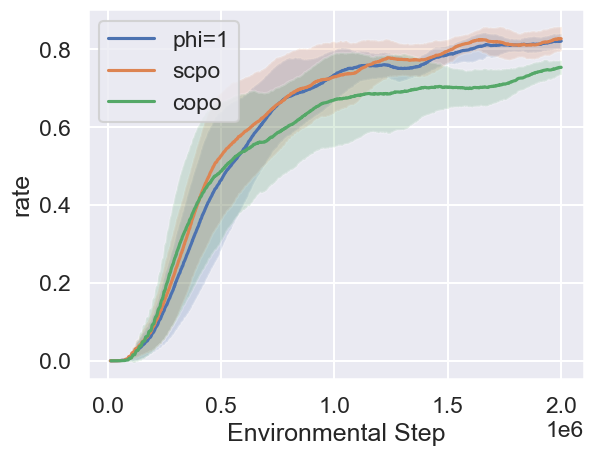

In [539]:
root_phi_1 = 'exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][phi]_coeff=1'
root_scpo_inter = 'eval_checkpoints/scpo/inter'
root_copo_inter = 'eval_checkpoints/copo/inter'
plot_one_exp(root_phi_1, exp_label='phi=1')
plot_one_exp(root_scpo_inter, exp_label='scpo')
plot_one_exp(root_copo_inter, exp_label='copo')

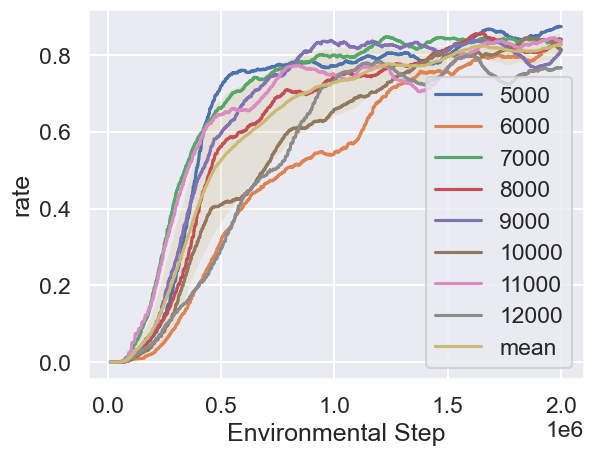

In [564]:
scpo_old = 'eval_checkpoints/scpo/inter_old'
plot_sep_mean(scpo_old)

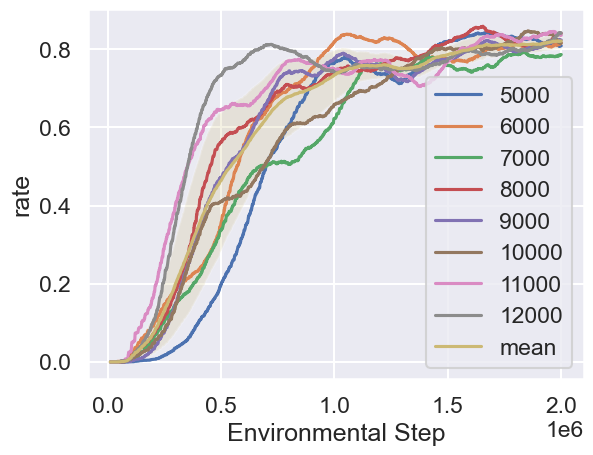

In [565]:
scpo_phi1 = 'exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][phi]_coeff=1'
plot_sep_mean(scpo_phi1)

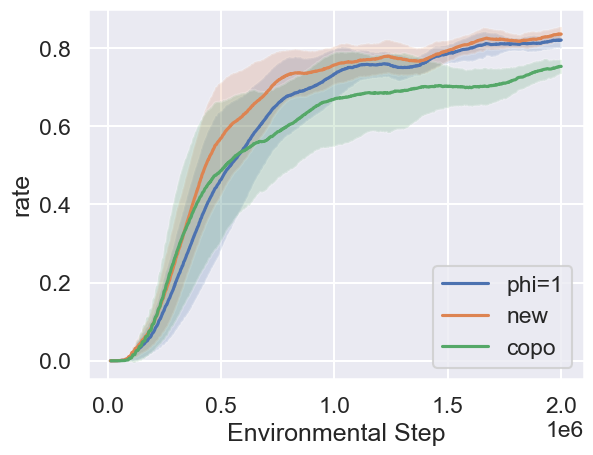

In [576]:
# plot_one_exp(scpo_old, exp_label='old')
plot_one_exp(scpo_phi1, exp_label='phi=1')
plot_one_exp('eval_checkpoints/scpo/inter', exp_label='new')
plot_one_exp(root_copo_inter, exp_label='copo')

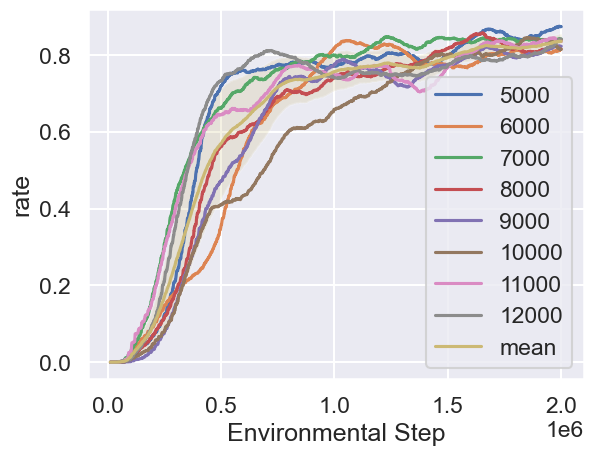

In [560]:
root_scpo_inter_new = 'eval_checkpoints/scpo/inter'
plot_sep_mean(root_scpo_inter_new)
plot_sep_mean(root_scpo_inter_new)

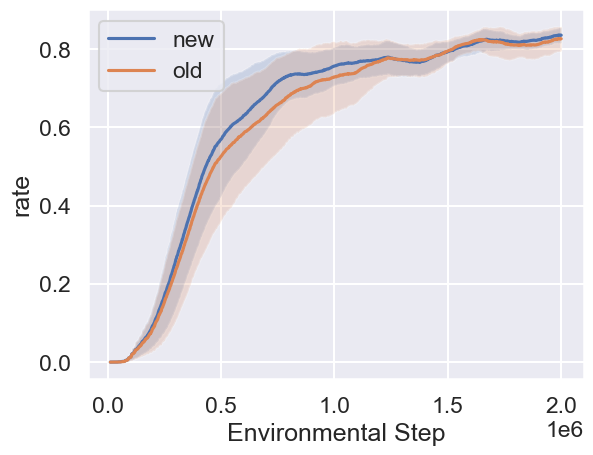

In [562]:
root_scpo_inter_new = 'eval_checkpoints/scpo/inter'
root_scpo_inter_old = 'eval_checkpoints/scpo/inter_old'
plot_one_exp(root_scpo_inter_new, exp_label='new')
plot_one_exp(root_scpo_inter_old, exp_label='old')

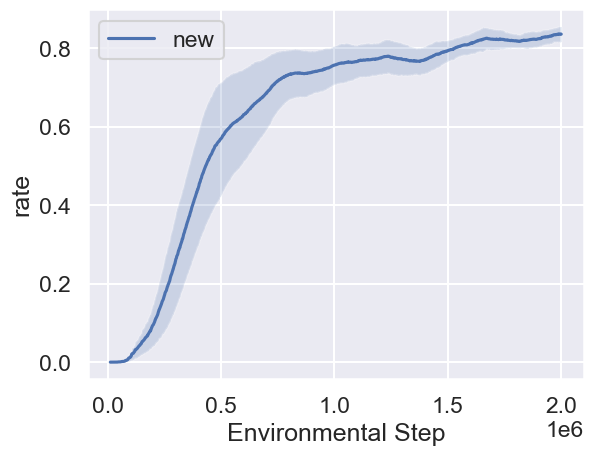

In [563]:
plot_one_exp(root_scpo_inter_new, exp_label='new')

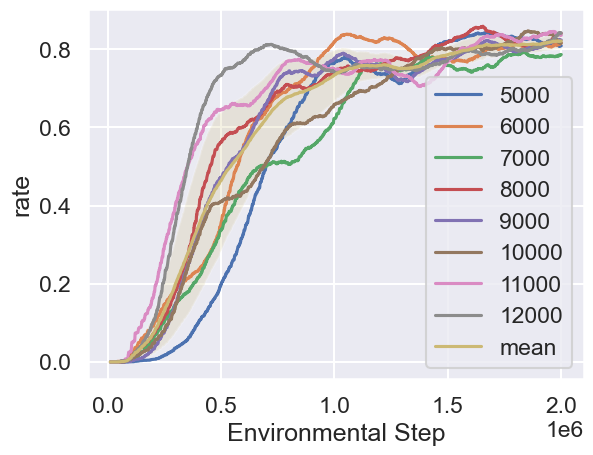

In [558]:
root_phi_1 = 'exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][phi]_coeff=1'
plot_sep_mean(root_phi_1, )

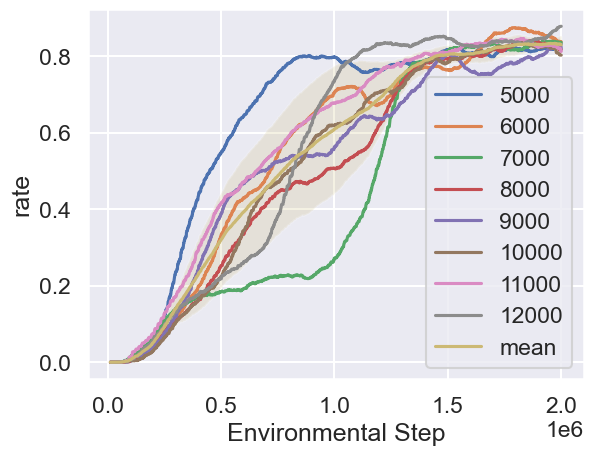

In [96]:
root4 = 'exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][phi]_coeff=2'
plot_sep_mean(root4, )

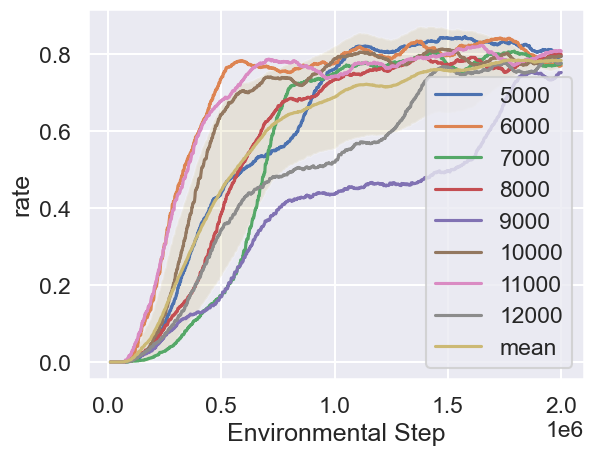

In [97]:
root5='exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][phi]_idv_nei_coeff=0.5'

# plot_one_exp(root5, param_pattern='8f8ea_00002', exp_label='1')
# plot_one_exp(root5, param_pattern='de707_00003', exp_label='2')
plot_sep_mean(root5, )

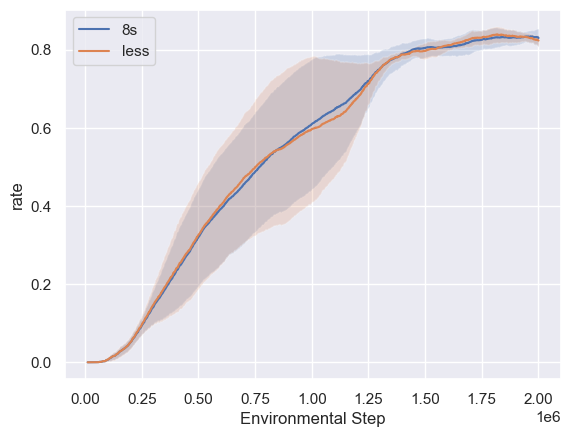

In [13]:
plot_one_exp(root4, exp_label='8s')
root4_2 = 'exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][phi]_coeff=2_less'
plot_one_exp(root4_2, exp_label='less')

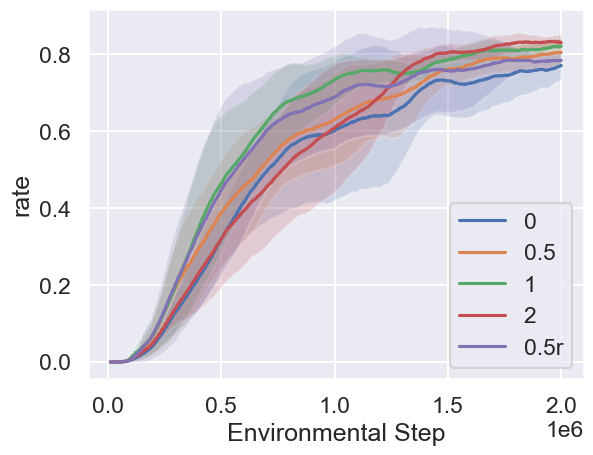

In [98]:
plot_one_exp(root1, exp_label='0')
plot_one_exp(root2, exp_label='0.5')
plot_one_exp(root3, exp_label='1')
plot_one_exp(root4, exp_label='2')
# plot_one_exp(root4_2, exp_label='2-less')
plot_one_exp(root5, exp_label='0.5r')

### Plot the learning curves for SuccRate & Failure 

In [192]:
roots = dict(
    root1='exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][phi]_coeff=0',
    root2='exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][phi]_coeff=0.5',
    root3='exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][phi]_coeff=1',
    root4='exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][phi]_coeff=2',
    # root_ippo='eval_checkpoints/ippo/inter',
    # 'φ=1': 'exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][phi]_idv_nei_coeff=0.5',
)
root_mapping = dict(
    root1=r"$\phi = 0$",
    root2=r"$\phi = 0.5$",
    root3=r"$\phi = 1$",
    root4=r"$\phi = 2$",
    # root_ippo='IPPO',
)

Read each dir of different hyper-params & concat:

In [178]:
data_list = []
for name, root in roots.items():
    data = smooth(parse_trials_in_dir(root))
    data['hyper-param'] = root_mapping[name]
    data_list.append(data)
all_results = pd.concat(data_list).reset_index()

Processing env <SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][phi]_coeff=0>...


100%|██████████| 8/8 [00:00<00:00, 13.41it/s]


Found 1954 points, draw 200 points.
Processing env <SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][phi]_coeff=0.5>...


100%|██████████| 7/7 [00:00<00:00, 14.17it/s]


Found 1954 points, draw 200 points.
Processing env <SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][phi]_coeff=1>...


100%|██████████| 8/8 [00:00<00:00, 14.31it/s]


Found 1954 points, draw 200 points.
Processing env <SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][phi]_coeff=2>...


100%|██████████| 8/8 [00:00<00:00, 14.44it/s]


Found 1954 points, draw 200 points.


calculate the `Failure` metric:

In [179]:
all_results['Failure'] = all_results['CrashRate'] + all_results['OutRate']

In [82]:
all_results.columns

Index(['index', 'episode_reward_max', 'episode_reward_min',
       'episode_reward_mean', 'episode_len_mean', 'episodes_this_iter',
       'num_faulty_episodes', 'num_healthy_workers',
       'num_in_flight_async_reqs', 'num_remote_worker_restarts',
       'num_agent_steps_sampled', 'num_agent_steps_trained',
       'num_env_steps_sampled', 'num_env_steps_trained',
       'num_env_steps_sampled_this_iter', 'num_env_steps_trained_this_iter',
       'num_env_steps_sampled_throughput_per_sec',
       'num_env_steps_trained_throughput_per_sec', 'timesteps_total',
       'num_steps_trained_this_iter', 'agent_timesteps_total', 'done',
       'episodes_total', 'training_iteration', 'trial_id', 'date', 'timestamp',
       'time_this_iter_s', 'time_total_s', 'pid', 'hostname', 'node_ip',
       'time_since_restore', 'iterations_since_restore', 'SuccessRate',
       'CrashRate', 'OutRate', 'MaxStepRate', 'RewardMean', 'StepMean',
       'DistanceMean', 'NeighboursMean', 'RewardsTotal', 'AgentsTo

Simple Preview:

/Users/jimmy/miniforge3/envs/marl/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


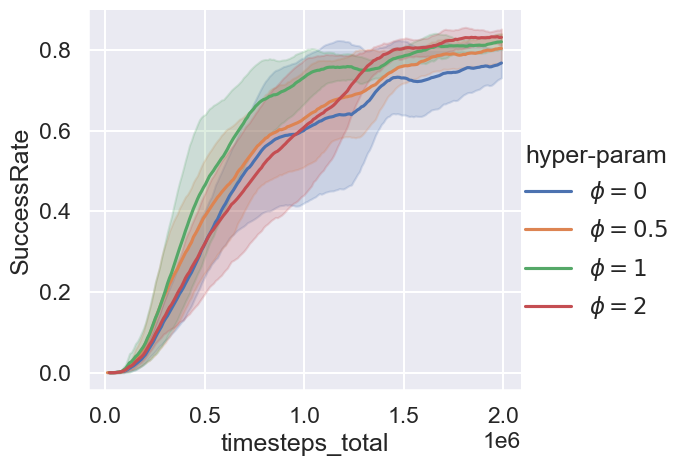

In [180]:
# Draw a little figure to see if data is processed properly.
sns.set("talk", "darkgrid")
ax = sns.relplot(
    x="timesteps_total",
    y="SuccessRate", 
    # y="CrashRate", 
    # y="Failure",
    hue='hyper-param',
    data=all_results.copy(),
    # ci="sd",
    errorbar='sd',
    kind="line",
    # col="env",
    aspect=1.15,
)

#### Formal Draw:

[<matplotlib.lines.Line2D object at 0x2d1975970>, <matplotlib.lines.Line2D object at 0x2d19750a0>, <matplotlib.lines.Line2D object at 0x2d19754c0>, <matplotlib.lines.Line2D object at 0x2d18a9610>] <class 'list'>


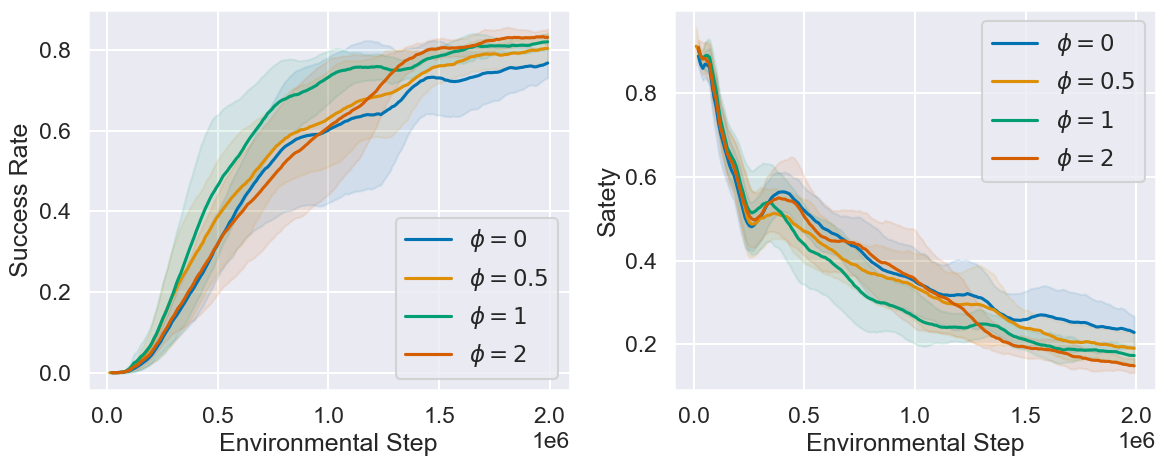

In [191]:
plot_df = all_results.copy()

x = "timesteps_total"

y1 = "SuccessRate"
y2 = "Failure"
y_label_1 = 'Success Rate'
y_label_2 = 'Satety'


c = sns.color_palette("colorblind")
sns.set("talk", "darkgrid")


# 创建一行两列的布局
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 在第一个子图中使用 lineplot 画图
sns.lineplot(
    x=x, 
    y=y1, 
    data=plot_df, 
    hue='hyper-param',
    legend={"title": ""},
    palette=list(c)[:len(plot_df['hyper-param'].unique())],
    errorbar='sd',
    err_kws=dict(alpha=0.1),
    ax=axes[0]
)
# axes[0].set_title('Lineplot for DataFrame 1')

# 在第二个子图中使用 lineplot 画图
sns.lineplot(
    x=x, 
    y=y2, 
    data=plot_df, 
    hue='hyper-param',
    legend='full',
    palette=list(c)[:len(plot_df['hyper-param'].unique())],
    errorbar='sd',
    err_kws=dict(alpha=0.1),
    ax=axes[1]
)
# axes[1].set_title('Lineplot for DataFrame 2')


# 设定标签
for axxx, y_label in zip(axes, [y_label_1, y_label_2]):
    axxx.set_xlabel("Environmental Step")
    axxx.set_ylabel(y_label)
    axxx.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
    axxx.legend_.set_title('')
    # axxx.legend_.set_visible(False)


hs, labels = axes[0].get_legend_handles_labels()
print(hs, type(hs))
fontsize=20
# legend_ax = ax.fig.add_axes([1., 0.9, 0.1, 0.1])
# fig.legend(
#     handles=hs, 
#     labels=labels,
#     title="", 
#     # title_fontsize=fontsize, 
#     # loc='best',
#     bbox_to_anchor=(0.8, 1.1), 
#     frameon=True,
#     ncol=5,
#     fontsize=fontsize*0.8,
#     labelspacing=0.8, 
#     handlelength=2.8
# )

# 调整布局
plt.subplots_adjust(top=1)
plt.tight_layout()

plt.savefig('ablation_phi.pdf', format='pdf', dpi=300, facecolor='#FFF', bbox_inches="tight")
plt.savefig('ablation_phi.png', format='png', dpi=200, facecolor='#FFF', bbox_inches="tight")

# 显示图形
plt.show()

## 2 different KL schedules:

### 2.1 The effectiveness of double actor knowledge distillation:

all exp:
|  | idv | team | | |
|:--:|:-----:|:----:|:----:|:---:|
|  1 | 0->2  | 3->1 | SCPO | 82% |
|  2 |       |      | IPPO | 70% |
|  3 |       |      |IPPO-RS | 62% |
|  4 |       |      |IPPO-DC | 30% |
|  5 | 2->2   | 0->0   | double actor w/o social policy distill | 40% |

In [548]:
roots_kl_1 = dict(
    root_scpo = 'eval_checkpoints/scpo/inter',
    root1 = 'eval_checkpoints/ippo/inter',
    root2 = 'exp_IPPO-RS/IPPO-RS_Inter_30agents_8workers_phi=1',
    # root2 = 'exp_IPPO-RS/IPPO-RS_Inter_30agents_8workers_phi=1_best',
    root3 = 'exp_IPPO-DC/IPPO-DC_Inter_30agents_8workers_phi=1',
    root4 = 'exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(2->2,0->0)',
)

root_mapping_kl_1 = dict(
    root_scpo='SCPO',
    root4='SCPO w/o CPO',
    root1='IPPO',
    root2='IPPO-RS',
    root3='IPPO-DC',
)

In [549]:
data_list = []
for name, root in roots_kl_1.items():
    data = smooth(parse_trials_in_dir(root))
    data['hyper-param'] = root_mapping_kl_1[name]
    data_list.append(data)
kl1_results = pd.concat(data_list).reset_index()

Processing env <inter>...


100%|██████████| 8/8 [00:00<00:00, 12.84it/s]


Found 1954 points, draw 200 points.
Processing env <inter>...


100%|██████████| 8/8 [00:00<00:00, 14.55it/s]


Found 1954 points, draw 200 points.
Processing env <IPPO-RS_Inter_30agents_8workers_phi=1>...


100%|██████████| 8/8 [00:00<00:00, 14.64it/s]


Found 1954 points, draw 200 points.
Processing env <IPPO-DC_Inter_30agents_8workers_phi=1>...


100%|██████████| 16/16 [00:01<00:00, 12.74it/s]


Found 1954 points, draw 200 points.
Processing env <SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(2->2,0->0)>...


100%|██████████| 8/8 [00:00<00:00, 13.94it/s]


Found 1954 points, draw 200 points.


In [224]:
kl1_results['Failure'] = kl1_results['CrashRate'] + kl1_results['OutRate']

[<matplotlib.lines.Line2D object at 0x2db5a35e0>, <matplotlib.lines.Line2D object at 0x2e25dbd60>, <matplotlib.lines.Line2D object at 0x2d85f48b0>, <matplotlib.lines.Line2D object at 0x2d85ec9a0>, <matplotlib.lines.Line2D object at 0x2d85ec250>] <class 'list'>


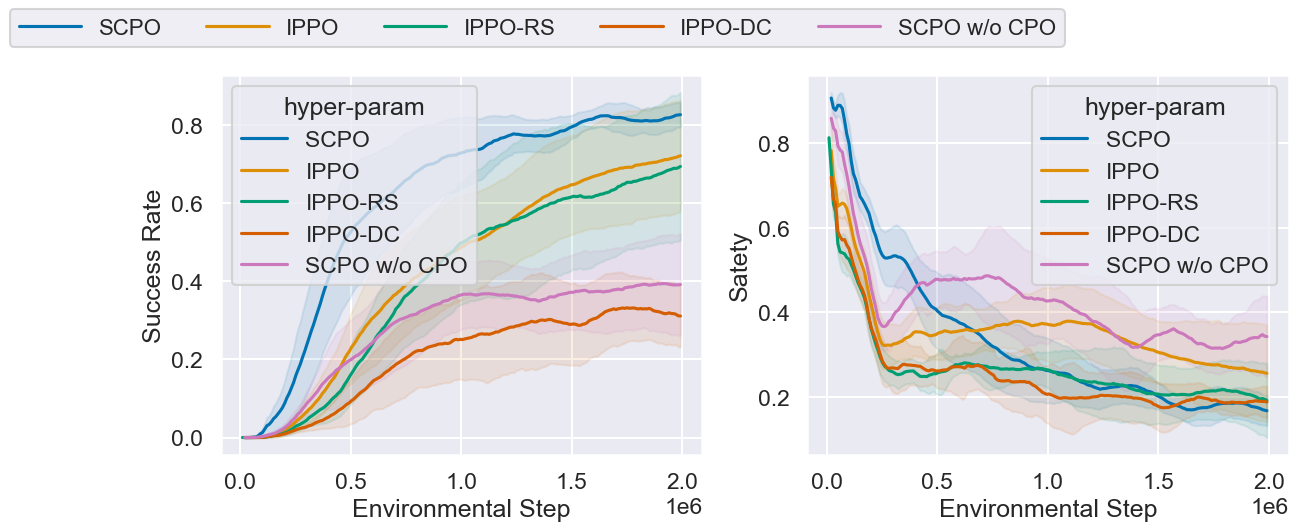

In [225]:
plot_df = kl1_results.copy()

x = "timesteps_total"

y1 = "SuccessRate"
y2 = "Failure"
y_label_1 = 'Success Rate'
y_label_2 = 'Satety'


c = sns.color_palette("colorblind")
sns.set("talk", "darkgrid")


# 创建一行两列的布局
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 在第一个子图中使用 lineplot 画图
sns.lineplot(
    x=x, 
    y=y1, 
    data=plot_df, 
    hue='hyper-param',
    legend={"title": ""},
    palette=list(c)[:len(plot_df['hyper-param'].unique())],
    errorbar='sd',
    err_kws=dict(alpha=0.1),
    ax=axes[0]
)
# axes[0].set_title('Lineplot for DataFrame 1')

# 在第二个子图中使用 lineplot 画图
sns.lineplot(
    x=x, 
    y=y2, 
    data=plot_df, 
    hue='hyper-param',
    palette=list(c)[:len(plot_df['hyper-param'].unique())],
    errorbar='sd',
    err_kws=dict(alpha=0.1),
    ax=axes[1]
)
# axes[1].set_title('Lineplot for DataFrame 2')


# 设定标签
for axxx, y_label in zip(axes, [y_label_1, y_label_2]):
    axxx.set_xlabel("Environmental Step")
    axxx.set_ylabel(y_label)
    axxx.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
    # axxx.legend_.set_visible(False)



hs, labels = axes[0].get_legend_handles_labels()
print(hs, type(hs))
fontsize=20
# legend_ax = ax.fig.add_axes([1., 0.9, 0.1, 0.1])
fig.legend(
    handles=hs, 
    labels=labels,
    title="", 
    # title_fontsize=fontsize, 
    # loc='best',
    bbox_to_anchor=(0.8, 1.1), 
    frameon=True,
    ncol=5,
    fontsize=fontsize*0.8,
    # fontsize=fontsize*0.3,
    labelspacing=0.8, 
    handlelength=2.8
)

# 调整布局
plt.subplots_adjust(top=1)
plt.tight_layout()

plt.savefig('ablation_CPO.pdf', format='pdf', dpi=300, facecolor='#FFF', bbox_inches="tight")
plt.savefig('ablation_CPO.png', format='png', dpi=200, facecolor='#FFF', bbox_inches="tight")

# 显示图形
plt.show()

plot one fig:

/Users/jimmy/miniforge3/envs/marl/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/36/bvf53yyd46b4pd8vg8rtv5fc0000gn/T/ipykernel_72362/1932788464.py:69: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


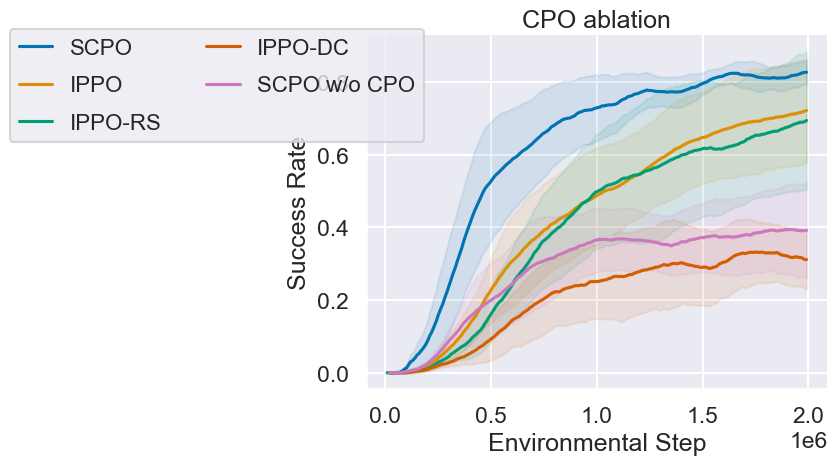

In [373]:
plot_df = kl1_results.copy()

x = "timesteps_total"

y = "SuccessRate"
y_label = 'Success Rate'

c = sns.color_palette("colorblind")
sns.set("talk", "darkgrid")

# fig, ax = plt.subplots(1, 1, figsize=(6, 5))

ax = sns.relplot(
    x=x,
    y=y, 
    hue='hyper-param',
    palette=list(c)[:len(plot_df['hyper-param'].unique())],
    data=plot_df,
    errorbar='sd',
    # legend=None,
    kind="line",
    # col="env",
    # facet_kws=dict(sharey=False, sharex=False),
#     linewidth=1,
#     height=5,
#     aspect=1.333,
    # facet_kws={"alpha": 0.1}
#     col_wrap=3,
    err_kws=dict(alpha=0.1),
    aspect=1.25,
#     linewidth=2,
#     legend=None
#     legend_out=False
#     facet_kws={"alpha": 0.2}
)
# 设定标题
for axxx in ax.axes.flat:
    axxx.set_title('CPO ablation')
    axxx.set_xlabel("Environmental Step")
    axxx.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
    # hs, labels = axxx.get_legend_handles_labels()
    # axxx.legend.set_visible(False)

# 设定标签
ax.set_ylabels(y_label)
ax.legend.set_visible(False)

# hs, labels = ax.get_legend_handles_labels()
hs = ax.legend.legend_handles
fontsize=20
plt.legend(
    handles=hs, 
    labels=labels,
    # title="", 
    # title_fontsize=fontsize, 
    # loc='best',
    bbox_to_anchor=(0.15, 1.05), 
    frameon=True,
    ncol=2,
    fontsize=fontsize*0.8,
    # fontsize=fontsize*0.65,
    labelspacing=0.8, 
    handlelength=1.5
)


# 调整布局
plt.subplots_adjust(top=1)
plt.tight_layout()

plt.savefig('ablation_CPO_1.pdf', format='pdf', dpi=300, facecolor='#FFF', bbox_inches="tight")
plt.savefig('ablation_CPO_1.png', format='png', dpi=200, facecolor='#FFF', bbox_inches="tight")

# 显示图形
plt.show()

### 2.2 different KL coeff scheduling:

all exp:
|   | idv    | team   | des  | succ rate |
|:-:|:------:|:------:|:----:|:---------:|
| 1 | 0->2   | 3->1   | SCPO | 82% |
| 2 | 0->0   | 0->0   | w/o both   | 30% |
| 3 | 0->2   | 0->0   | w/o alpha (social term) | 50% |
| 4 | 2->2   | 3->1   | w/o beta (idv term) | 70% |

In [436]:
roots_kl_2 = dict(
    root1 = 'eval_checkpoints/scpo/inter',
    root2 = 'exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(0->0,0->0)',
    root3 = 'exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(0->2,0->0)',
    root4 = 'exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(2->2,3->1)',
    # root4 = 'exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(0->0,3->1)',
    root_no_cpo = 'exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(2->2,0->0)',
    root_ippo_rs = 'exp_IPPO-RS/IPPO-RS_Inter_30agents_8workers_phi=1_best',
)
root_mapping_kl_2 = dict(
    root1='SCPO',
    root2=r'SCPO w/o $\alpha$ & $\beta$',
    root3=r'SCPO w/o $\alpha$',
    root4=r'SCPO w/o $\beta$',
    root_no_cpo='SCPO w/o CPO',
    root_ippo_rs='IPPO-RS',
)

In [213]:
data_list = []
for name, root in roots_kl_2.items():
    data = smooth(parse_trials_in_dir(root))
    data['hyper-param'] = root_mapping_kl_2[name]
    data_list.append(data)
all_results = pd.concat(data_list).reset_index()

Processing env <inter>...


100%|██████████| 8/8 [00:00<00:00, 12.32it/s]


Found 1954 points, draw 200 points.
Processing env <SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(0->0,0->0)>...


100%|██████████| 8/8 [00:00<00:00, 13.06it/s]


Found 1954 points, draw 200 points.
Processing env <SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(0->2,0->0)>...


100%|██████████| 8/8 [00:00<00:00, 12.53it/s]


Found 1954 points, draw 200 points.
Processing env <SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(2->2,3->1)>...


100%|██████████| 9/9 [00:00<00:00, 12.81it/s]


Found 1954 points, draw 200 points.
Processing env <SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(2->2,0->0)>...


100%|██████████| 8/8 [00:00<00:00, 13.06it/s]


Found 1954 points, draw 200 points.
Processing env <IPPO-RS_Inter_30agents_8workers_phi=1_best>...


100%|██████████| 8/8 [00:00<00:00, 13.01it/s]


Found 1954 points, draw 200 points.


[<matplotlib.lines.Line2D object at 0x2d1468d90>, <matplotlib.lines.Line2D object at 0x2d1468d60>, <matplotlib.lines.Line2D object at 0x2cfafef40>, <matplotlib.lines.Line2D object at 0x2cfafe3d0>, <matplotlib.lines.Line2D object at 0x2cfafeeb0>, <matplotlib.lines.Line2D object at 0x2cfafec70>] <class 'list'>


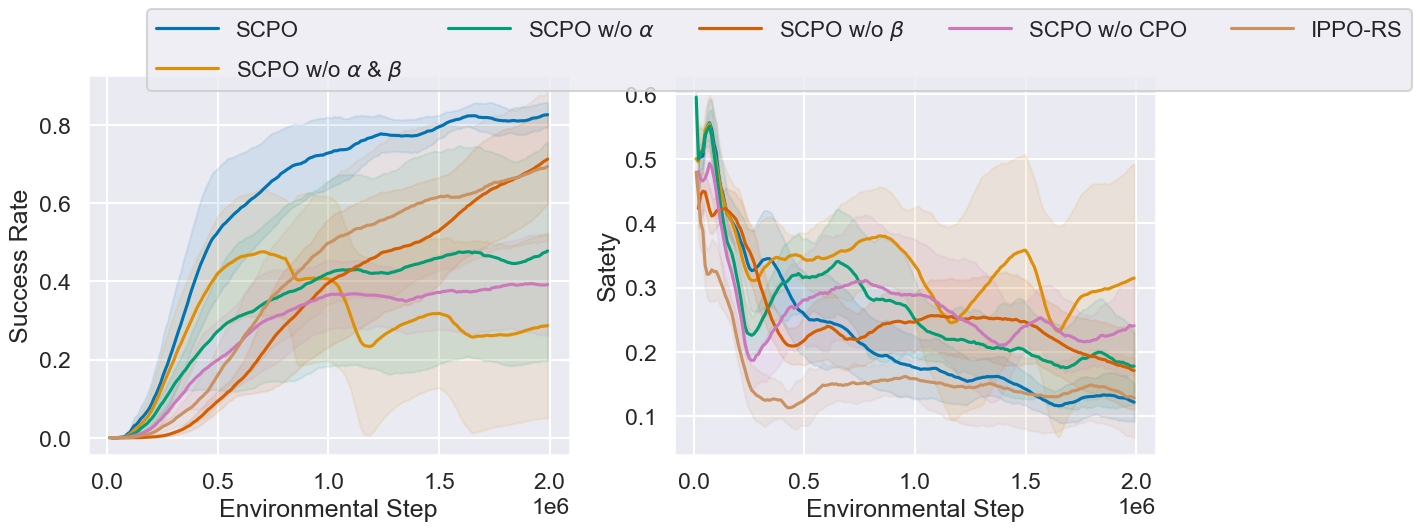

In [218]:
plot_df = all_results.copy()

x = "timesteps_total"

y1 = "SuccessRate"
y2 = "CrashRate"
y_label_1 = 'Success Rate'
y_label_2 = 'Satety'


c = sns.color_palette("colorblind")
sns.set("talk", "darkgrid")


# 创建一行两列的布局
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 在第一个子图中使用 lineplot 画图
sns.lineplot(
    x=x, 
    y=y1, 
    data=plot_df, 
    hue='hyper-param',
    legend={"title": ""},
    palette=list(c)[:len(plot_df['hyper-param'].unique())],
    errorbar='sd',
    err_kws=dict(alpha=0.1),
    ax=axes[0]
)
# axes[0].set_title('Lineplot for DataFrame 1')

# 在第二个子图中使用 lineplot 画图
sns.lineplot(
    x=x, 
    y=y2, 
    data=plot_df, 
    hue='hyper-param',
    palette=list(c)[:len(plot_df['hyper-param'].unique())],
    errorbar='sd',
    err_kws=dict(alpha=0.1),
    ax=axes[1]
)
# axes[1].set_title('Lineplot for DataFrame 2')


# 设定标签
for axxx, y_label in zip(axes, [y_label_1, y_label_2]):
    axxx.set_xlabel("Environmental Step")
    axxx.set_ylabel(y_label)
    axxx.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
    axxx.legend_.set_visible(False)


hs, labels = axes[0].get_legend_handles_labels()
print(hs, type(hs))
fontsize=20
# legend_ax = ax.fig.add_axes([1., 0.9, 0.1, 0.1])
fig.legend(
    handles=hs, 
    labels=labels,
    title="", 
    # title_fontsize=fontsize, 
    # loc='best',
    bbox_to_anchor=(1.2, 1.1), 
    frameon=True,
    ncol=5,
    fontsize=fontsize*0.8,
    labelspacing=0.8, 
    handlelength=2.8
)

# 调整布局
plt.subplots_adjust(top=1)
plt.tight_layout()

plt.savefig('ablation_KL.pdf', format='pdf', dpi=300, facecolor='#FFF', bbox_inches="tight")
plt.savefig('ablation_KL.png', format='png', dpi=200, facecolor='#FFF', bbox_inches="tight")

# 显示图形
plt.show()

### 2.3 draw 2 ablation studies in 1 plot:

In [609]:
roots_kl_1 = dict(
    root_scpo = 'eval_checkpoints/scpo/inter',
    root5 = 'exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(2->2,3->3)',
    root4 = 'exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(2->2,0->0)',
    root1 = 'eval_checkpoints/ippo/inter',
    root2 = 'exp_IPPO-RS/IPPO-RS_Inter_30agents_8workers_phi=1',
    # root2 = 'exp_IPPO-RS/IPPO-RS_Inter_30agents_8workers_phi=1_best',
    root3 = 'exp_IPPO-DC/IPPO-DC_Inter_30agents_8workers_phi=1',
)

root_mapping_kl_1 = dict(
    root_scpo='SCPO',
    root1='IPPO',
    root2='IPPO-RS',
    root3='IPPO-DC',
    root4='SCPO w/o CPO',
    root5='SCPO w/o SCH',
)

data_list = []
for name, root in roots_kl_1.items():
    data = smooth(parse_trials_in_dir(root), num_points=400)
    data['hyper-param'] = root_mapping_kl_1[name]
    data_list.append(data)
abl_kl1_results = pd.concat(data_list).reset_index()

Processing env <inter>...


100%|██████████| 8/8 [00:00<00:00, 12.48it/s]


Found 1954 points, draw 400 points.
Processing env <SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(2->2,3->3)>...


100%|██████████| 8/8 [00:00<00:00, 13.72it/s]


Found 1954 points, draw 400 points.
Processing env <SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(2->2,0->0)>...


100%|██████████| 8/8 [00:00<00:00, 13.55it/s]


Found 1954 points, draw 400 points.
Processing env <inter>...


100%|██████████| 8/8 [00:00<00:00, 13.96it/s]


Found 1954 points, draw 400 points.
Processing env <IPPO-RS_Inter_30agents_8workers_phi=1>...


100%|██████████| 8/8 [00:00<00:00, 13.85it/s]


Found 1954 points, draw 400 points.
Processing env <IPPO-DC_Inter_30agents_8workers_phi=1>...


100%|██████████| 16/16 [00:01<00:00, 12.85it/s]


Found 1954 points, draw 400 points.


In [610]:
roots_kl_2 = dict(
    root1 = 'eval_checkpoints/scpo/inter',
    # root_no_cpo = 'exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(2->2,0->0)',
    root5 = 'exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(0->2,3->3)',
    root6 = 'exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(2->2,3->1)',
    root3 = 'exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(0->2,0->0)',
    root4 = 'exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(0->0,3->1)',
    root2 = 'exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(0->0,0->0)',
    # root_ippo_rs = 'exp_IPPO-RS/IPPO-RS_Inter_30agents_8workers_phi=1_best',
)
root_mapping_kl_2 = dict(
    root1='SCPO',
    root2=r'SCPO w/o $\alpha$ & $\beta$',
    root3=r'SCPO w/o $\alpha$',
    root4=r'SCPO w/o $\beta$',
    root5=r'SCPO w/ fixed $\alpha$',
    root6=r'SCPO w/ fixed $\beta$',
    root_no_cpo='SCPO w/o CPO',
    # root_ippo_rs='IPPO-RS',
)
data_list = []
for name, root in roots_kl_2.items():
    data = smooth(parse_trials_in_dir(root), num_points=400)
    data['hyper-param'] = root_mapping_kl_2[name]
    data_list.append(data)
abl_kl2_results = pd.concat(data_list).reset_index()

Processing env <inter>...


100%|██████████| 8/8 [00:00<00:00, 13.60it/s]


Found 1954 points, draw 400 points.
Processing env <SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(0->2,3->3)>...


100%|██████████| 8/8 [00:00<00:00, 13.75it/s]


Found 1954 points, draw 400 points.
Processing env <SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(2->2,3->1)>...


100%|██████████| 8/8 [00:00<00:00, 13.84it/s]


Found 1954 points, draw 400 points.
Processing env <SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(0->2,0->0)>...


100%|██████████| 8/8 [00:00<00:00, 13.42it/s]


Found 1954 points, draw 400 points.
Processing env <SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(0->0,3->1)>...


100%|██████████| 8/8 [00:00<00:00, 13.52it/s]


Found 1954 points, draw 400 points.
Processing env <SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(0->0,0->0)>...


100%|██████████| 8/8 [00:00<00:00, 13.46it/s]


Found 1954 points, draw 400 points.


['_PROPERTIES_EXCLUDED_FROM_SET', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_agg_filter', '_alignment', '_alpha', '_animated', '_auto_legend_data', '_axes', '_bbox_to_anchor', '_callbacks', '_clipon', '_clippath', '_cm_set', '_custom_handler_map', '_default_contains', '_default_handler_map', '_draggable', '_find_best_position', '_findoffset', '_fontsize', '_fully_clipped_to_axes', '_get_anchored_bbox', '_get_loc', '_gid', '_in_layout', '_init_legend_box', '_internal_update', '_label', '_legend_box', '_legend_handle_box', '_legend_title_box', '_loc', '_loc_real', '_loc_used_default', '_mode', '_mouseover', '_ncols', '_outside_loc', '_path_effects', '_picker', '_rasterized',

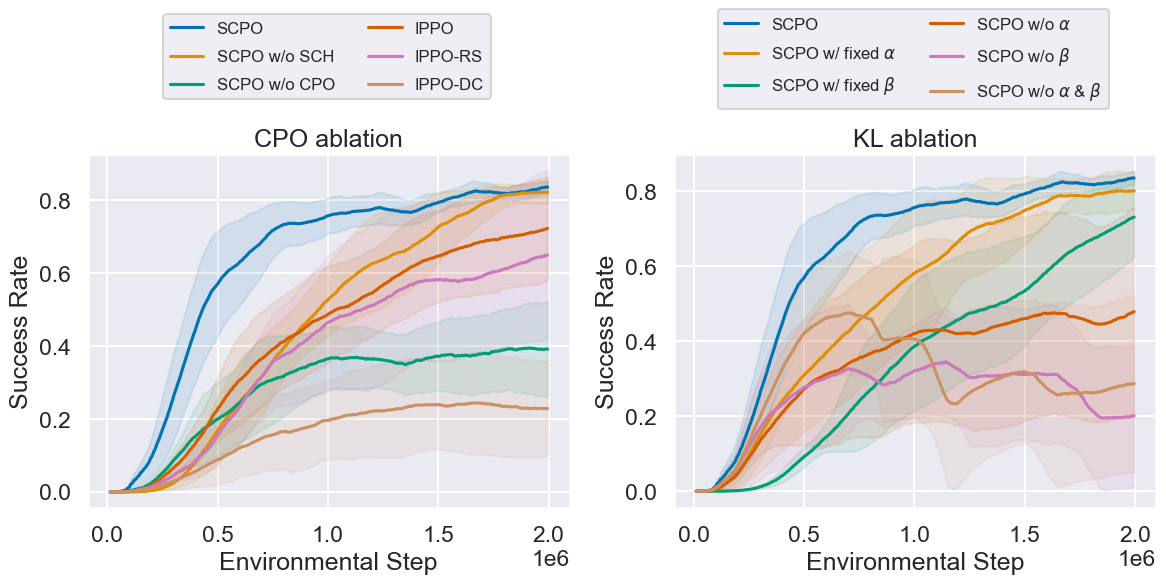

In [611]:
x = "timesteps_total"

y1 = "SuccessRate"
y_label_1 = 'Success Rate'
y_title_1 = 'CPO ablation'

y2 = "SuccessRate"
y_label_2 = 'Success Rate'
y_title_2 = 'KL ablation'

c = sns.color_palette("colorblind")
sns.set("talk", "darkgrid")
# sns.set(rc={"legend.fontsize": 20})

# 创建一行两列的布局
fig, axes = plt.subplots(1, 2, figsize=(12., 5))
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 在第一个子图中使用 lineplot 画图
sns.lineplot(
    x=x, 
    y=y1, 
    data=abl_kl1_results, 
    hue='hyper-param',
    legend={"title": "", "fontsize":10,},
    palette=list(c)[:len(abl_kl1_results['hyper-param'].unique())],
    errorbar='sd',
    err_kws=dict(alpha=0.1),
    ax=axes[0]
)
# axes[0].set_title('Lineplot for DataFrame 1')

# 在第二个子图中使用 lineplot 画图
sns.lineplot(
    x=x, 
    y=y2, 
    data=abl_kl2_results, 
    hue='hyper-param',
    palette=list(c)[:len(abl_kl2_results['hyper-param'].unique())],
    errorbar='sd',
    err_kws=dict(alpha=0.1),
    ax=axes[1]
)
# axes[1].set_title('Lineplot for DataFrame 2')

# 设定标签
for axxx, y_label, y_title in zip(axes, [y_label_1, y_label_2], [y_title_1, y_title_2]):
    axxx.set_title(y_title)
    axxx.set_xlabel("Environmental Step")
    axxx.set_ylabel(y_label)
    axxx.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
    axxx.legend_.set_title('')
    print(dir(axxx.legend_))
    # axxx.legend_.set_bbox_to_anchor((0.25, 0.85))
    # for item in axxx.legend_.get_texts():
    #     item.set_fontsize(14)
   
    axxx.legend_.set_visible(False)

hs, labels = axes[0].get_legend_handles_labels()
print(hs, type(hs))
fontsize=20
# legend_ax = ax.fig.add_axes([1., 0.9, 0.1, 0.1])
fig.legend(
    handles=hs, 
    labels=labels,
    title="", 
    # title_fontsize=fontsize, 
    # loc='best',
    bbox_to_anchor=(0.43, 1.19), 
    frameon=True,
    ncol=2,
    fontsize=fontsize*0.6,
    # fontsize=fontsize*0.3,
    labelspacing=0.8, 
    handlelength=2
)

hs, labels = axes[1].get_legend_handles_labels()
print(hs, type(hs))
fontsize=20
# legend_ax = ax.fig.add_axes([1., 0.9, 0.1, 0.1])
fig.legend(
    handles=hs, 
    labels=labels,
    title="", 
    # title_fontsize=fontsize, 
    # loc='best',
    bbox_to_anchor=(0.945, 1.2), 
    frameon=True,
    ncol=2,
    fontsize=fontsize*0.6,
    # fontsize=fontsize*0.3,
    labelspacing=0.8, 
    handlelength=2
)

# 调整布局
plt.subplots_adjust(top=1)
plt.tight_layout()

plt.savefig('ablation_2.pdf', format='pdf', dpi=300, facecolor='#FFF', bbox_inches="tight")
plt.savefig('ablation_2.png', format='png', dpi=200, facecolor='#FFF', bbox_inches="tight")

# 显示图形
plt.show()

### Others:


|    | idv | team | succ rate | variant |
|:--:|:------:|:------:|:---:|:---:|
|  1 | 0->0   | 0->0   | 30% | w/o alpha & beta |
|  2 | 0->0   | 3->1   | 20% | w/o beta  |
|  3 | 0->2   | 0->0   | 50% | w/o alpha |
|  4 | 0->2   | 3->3   | 80% |   |
|  5 | 2->2   | 0->0   | 40% | w/o CPO |
|  6 | 2->2   | 3->1   | 70% | fixed beta |
|  7 | 2->2   | 3->3   | 80% |

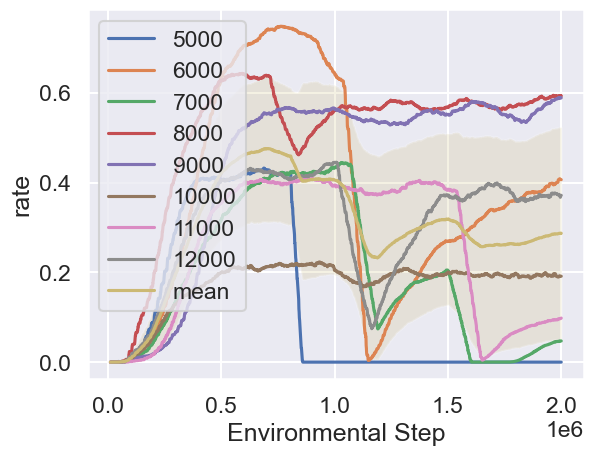

In [138]:
root_kl_1 = 'exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(0->0,0->0)'
plot_sep_mean(root_kl_1)

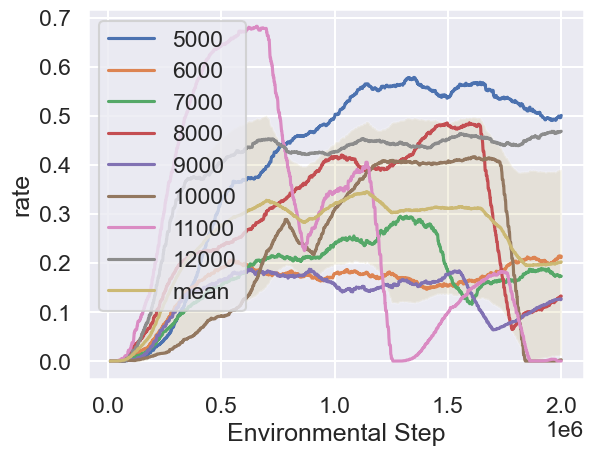

In [193]:
root_kl_2 = 'exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(0->0,3->1)'
plot_sep_mean(root_kl_2)

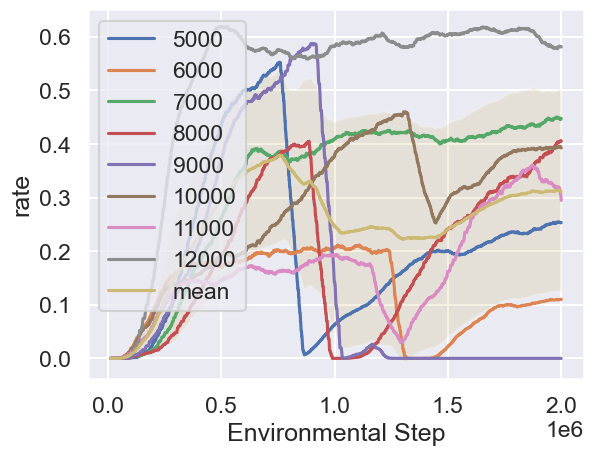

In [637]:
_r = '/Users/jimmy/Downloads/SCPO_Inter_30agents_8workers_8seeds_2M_lr=3e-5_[ablation][sl]_(0->0,3->1)2_[CSV]'
plot_sep_mean(_r)

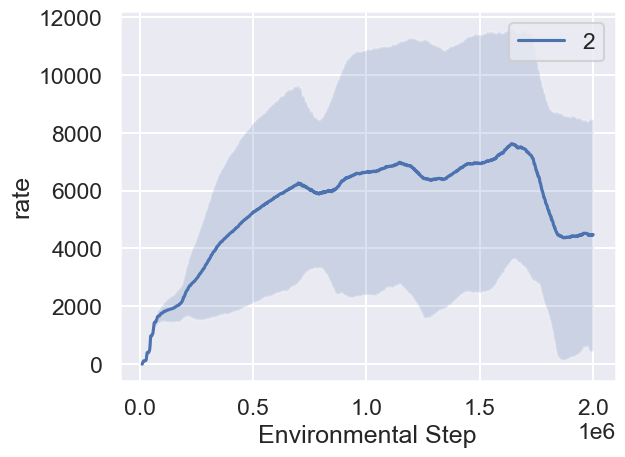

In [194]:
plot_one_exp(root_kl_2, exp_label='2', col=reward_mean_col,)

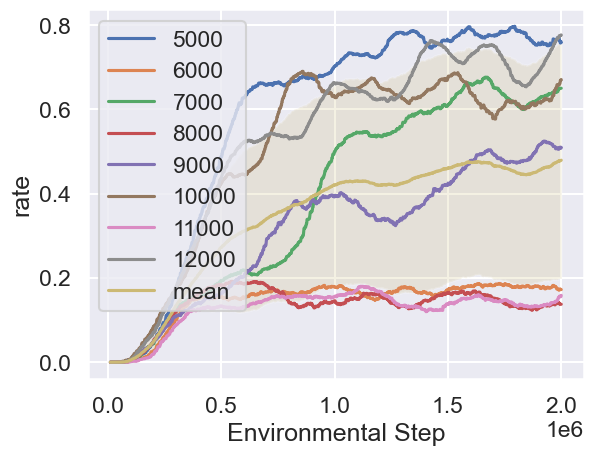

In [140]:
root_kl_2 = 'exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(0->2,0->0)'
plot_sep_mean(root_kl_2)

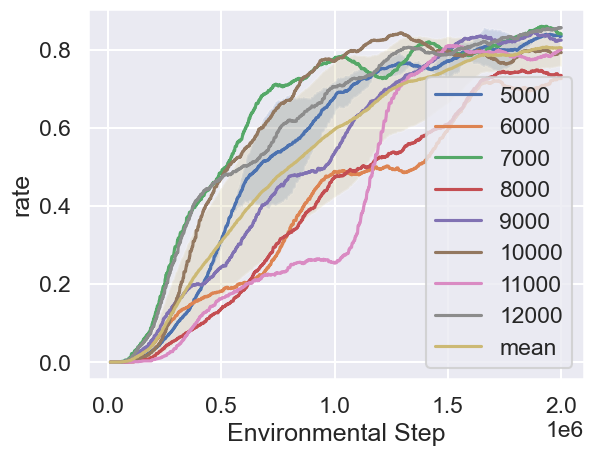

In [141]:
root_kl_3 = 'exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(0->2,3->3)'
plot_sep_mean(root_kl_3)

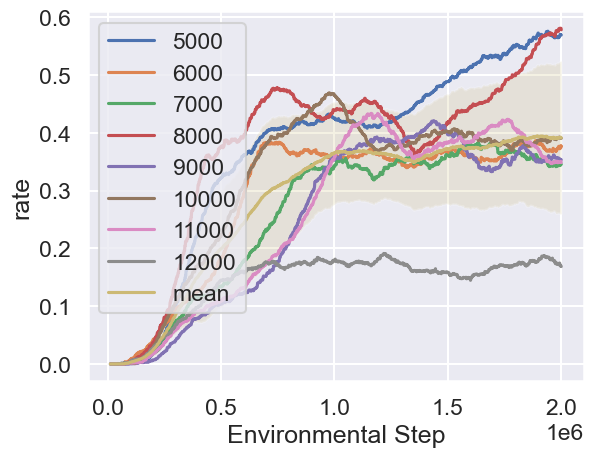

In [142]:
root_kl_4 = 'exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(2->2,0->0)'
plot_sep_mean(root_kl_4)

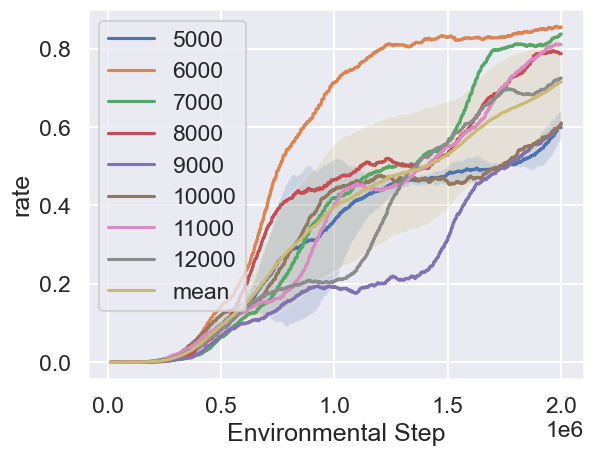

In [143]:
root_kl_5 = 'exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(2->2,3->1)'
plot_sep_mean(root_kl_5)

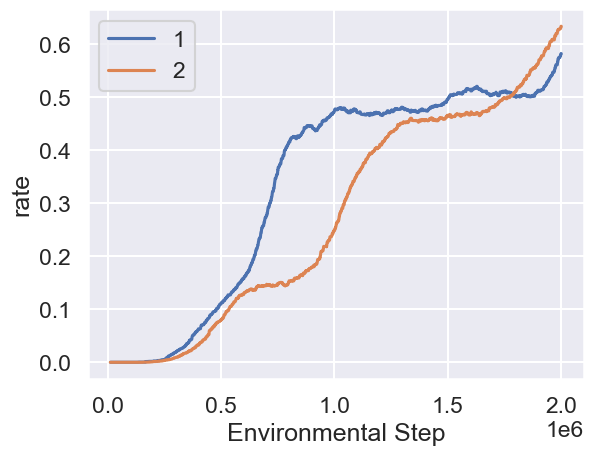

In [608]:
root_kl_5 = 'exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(2->2,3->1)'
plot_one_exp(root_kl_5, exp_label='1', param_pattern='d07af')
plot_one_exp(root_kl_5, exp_label='2', param_pattern='20639_00000')

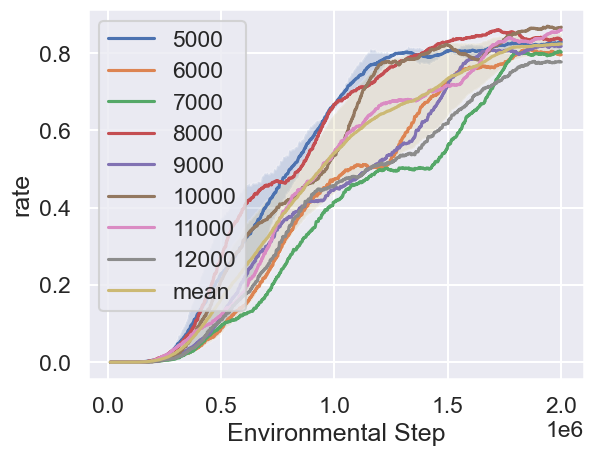

In [144]:
root_kl_6 = 'exp_SCPO/ABLATION/SCPO_Inter_30agents_8workers_2M_lr=3e-5_[ablation][sl]_(2->2,3->3)'
plot_sep_mean(root_kl_6)

ALL:

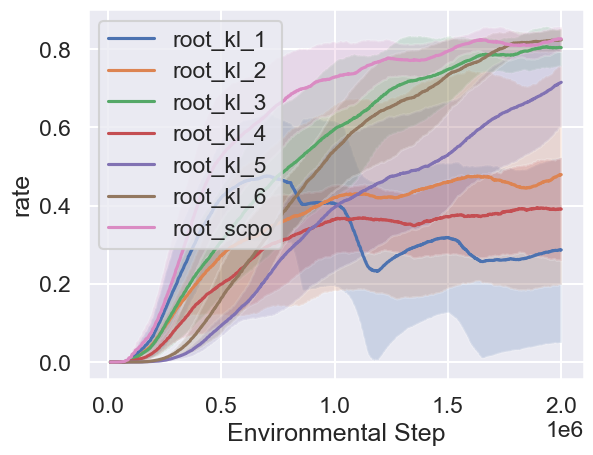

In [146]:
roots_kl = dict(
    root_kl_1=root_kl_1,
    root_kl_2=root_kl_2,
    root_kl_3=root_kl_3,
    root_kl_4=root_kl_4,
    root_kl_5=root_kl_5,
    root_kl_6=root_kl_6,
    root_scpo='eval_checkpoints/scpo/inter',
)

for name, root in roots_kl.items():
    plot_one_exp(root, exp_label=name)

IPPO-RS:

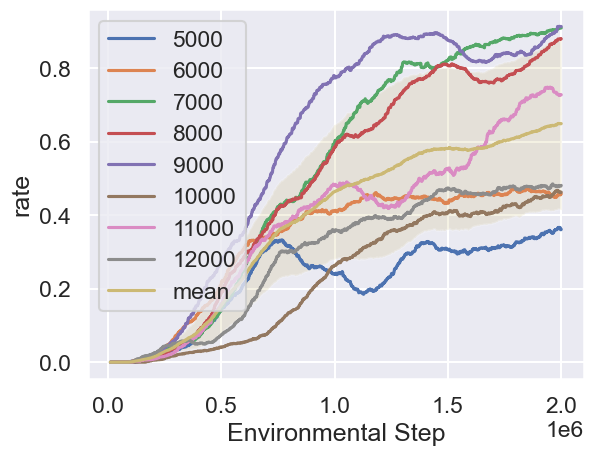

In [540]:
root_rs_1 = 'exp_IPPO-RS/IPPO-RS_Inter_30agents_8workers_phi=1'
plot_sep_mean(root_rs_1)

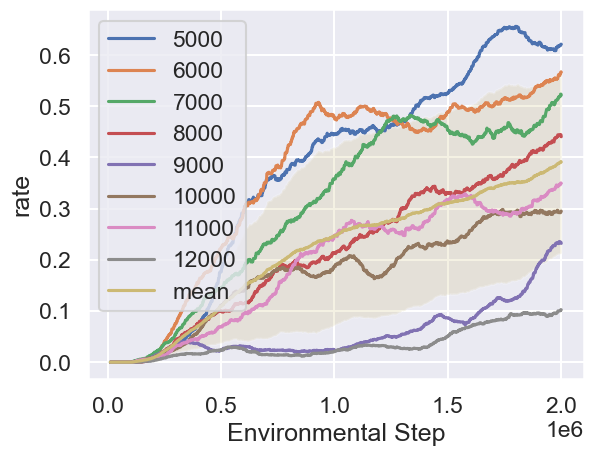

In [541]:
root_rs_2 = 'exp_IPPO-RS/IPPO-RS_Inter_30agents_8workers_phi=1_2'
plot_sep_mean(root_rs_2)

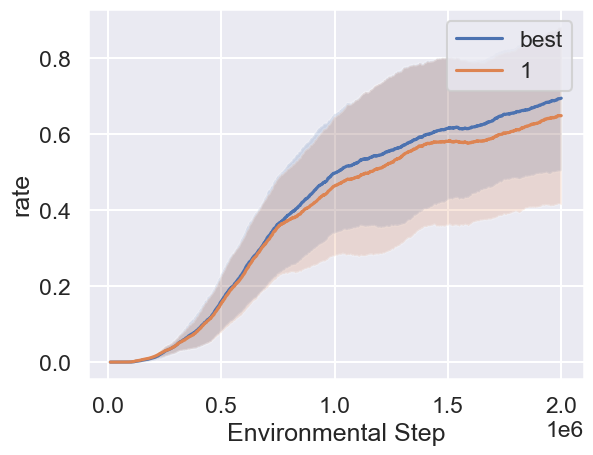

In [542]:
root_rs_3 = 'exp_IPPO-RS/IPPO-RS_Inter_30agents_8workers_phi=1_best'
plot_one_exp(root_rs_3, exp_label='best')
plot_one_exp(root_rs_1, exp_label='1')

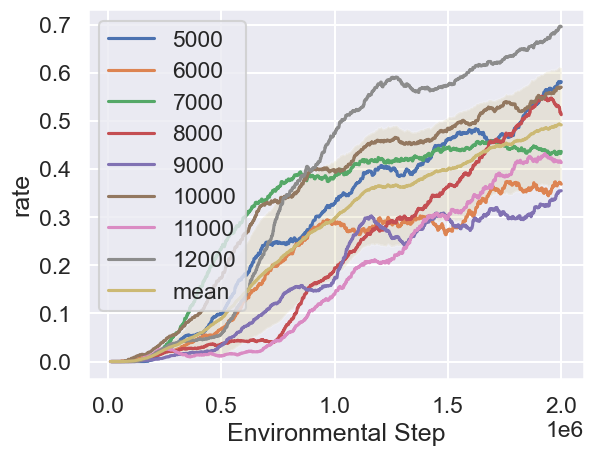

In [543]:
root_rs_05 = 'exp_IPPO-RS/IPPO-RS_Inter_30agents_8workers_phi=0.5'
plot_sep_mean(root_rs_05)

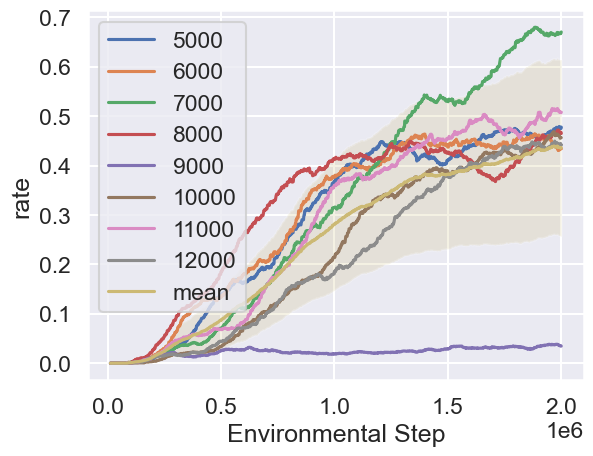

In [544]:
root_rs_phi2='exp_IPPO-RS/IPPO-RS_Inter_30agents_8workers_phi=2'
plot_sep_mean(root_rs_phi2)

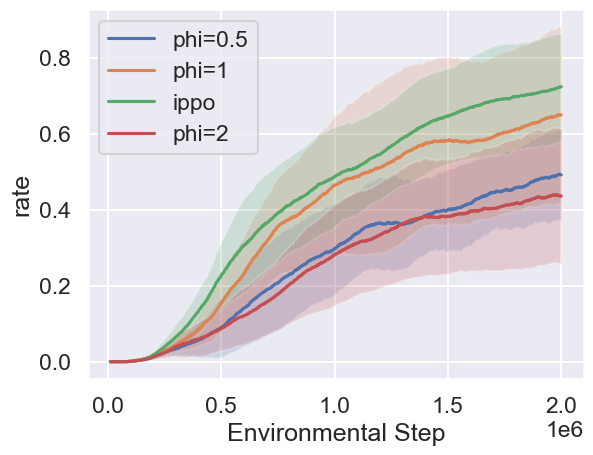

In [547]:
plot_one_exp(root_rs_05, exp_label='phi=0.5')
plot_one_exp(root_rs_1, exp_label='phi=1')
plot_one_exp('eval_checkpoints/ippo/inter', exp_label='ippo')
# plot_one_exp(root_rs_3, exp_label='phi=1_best')

plot_one_exp(root_rs_phi2, exp_label='phi=2')


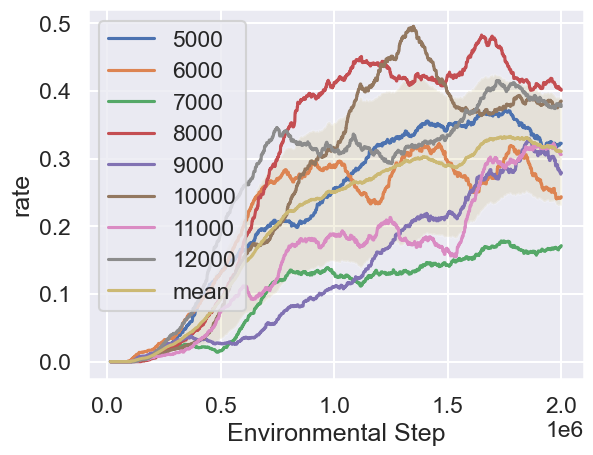

In [163]:
root_dc = 'exp_IPPO-DC/IPPO-DC_Inter_30agents_8workers_phi=1'
plot_sep_mean(root_dc)

In [168]:
from marlpo.utils.plot import reward_mean_col

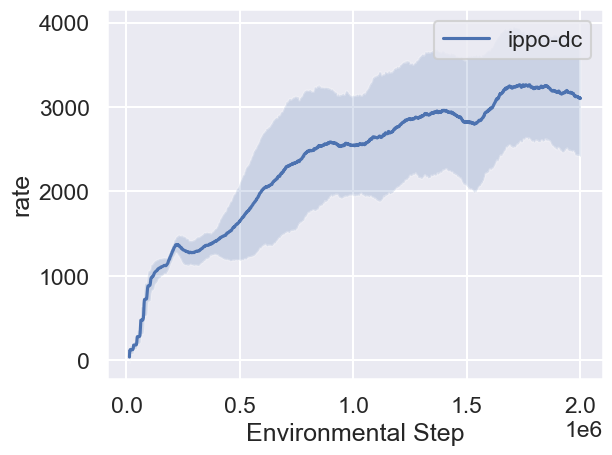

In [170]:
plot_one_exp(root_dc, exp_label='ippo-dc', col=reward_mean_col,)

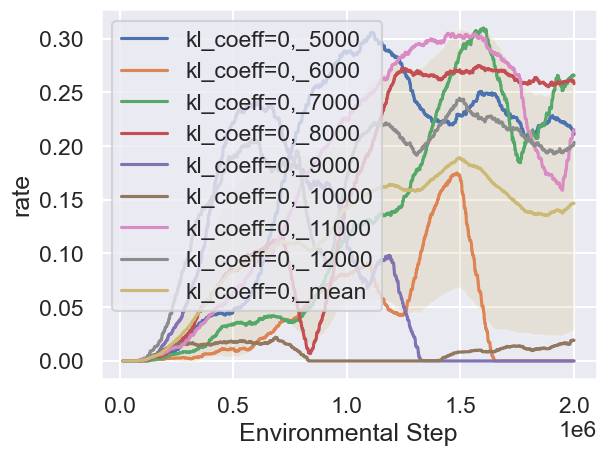

In [532]:
root_dc_2 = 'exp_IPPO-DC/IPPO-DC_Inter_30agents_8workers_phi=1'
plot_sep_mean(root_dc_2, p='kl_coeff=0,')

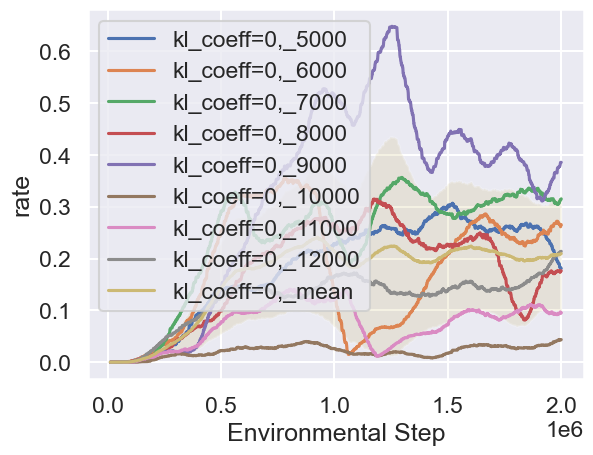

In [533]:
root_dc_3 = 'exp_IPPO-DC/IPPO-DC_Inter_30agents_8workers_phi=1_(3)'
plot_sep_mean(root_dc_3, p='kl_coeff=0,')

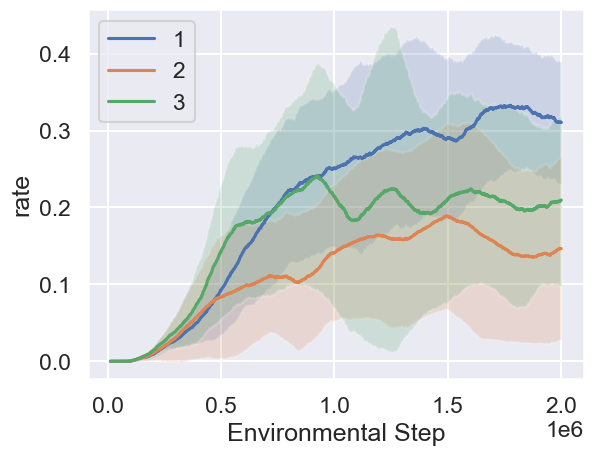

In [537]:
plot_one_exp(root_dc, exp_label='1', param_pattern='ef131')
plot_one_exp(root_dc_2, exp_label='2', param_pattern='85875')
plot_one_exp(root_dc_3, exp_label='3', )

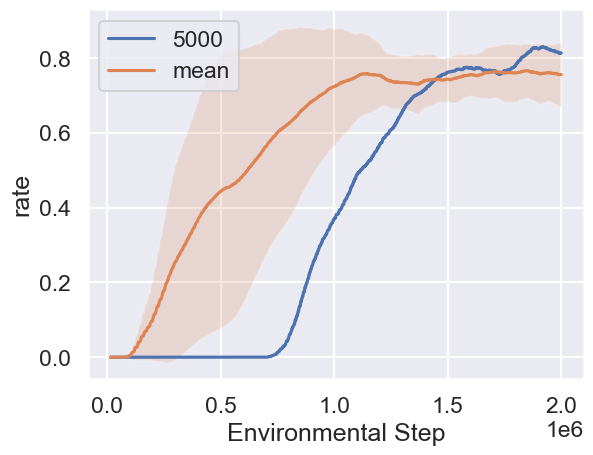

In [633]:
scpo_r = 'eval_checkpoints/copo/round'
# plot_sep_mean(scpo_r, )
plot_sep_mean(scpo_r, seeds=[5000])

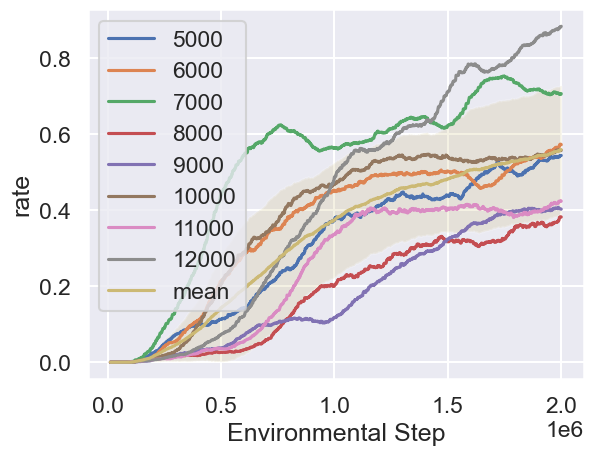

In [634]:
ippo_rs_0 = 'exp_IPPO-RS/IPPO-RS_Inter_30agents_8workers_phi=0'
plot_sep_mean(ippo_rs_0)

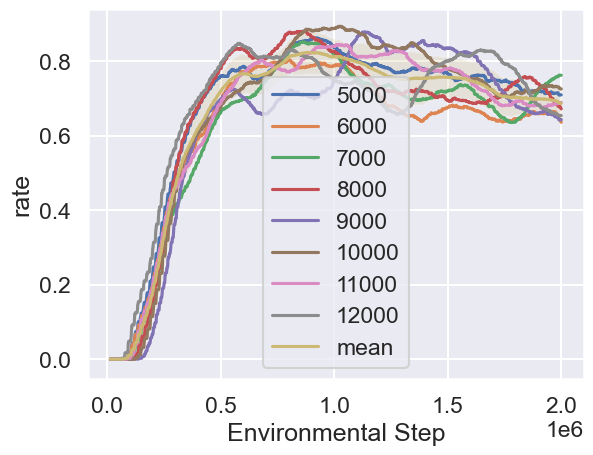

In [635]:
copo_r_ai = 'exp_CoPO/CoPO_Round_40agents_8workers_2M_8seeds_lr=3e-5[AIBoy]'
plot_sep_mean(copo_r_ai)

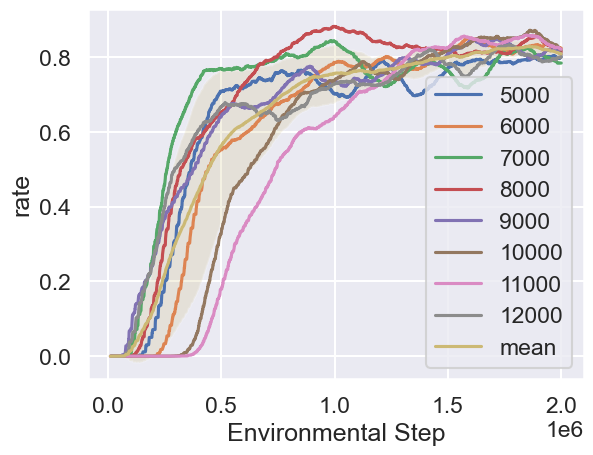

In [636]:
scpop_r_ai = 'exp_SCPO/SUCCESS/SCPO_Round_40agents_8workers_8seeds_2M_lr=3e-5[new]'
plot_sep_mean(scpop_r_ai)

COPO:

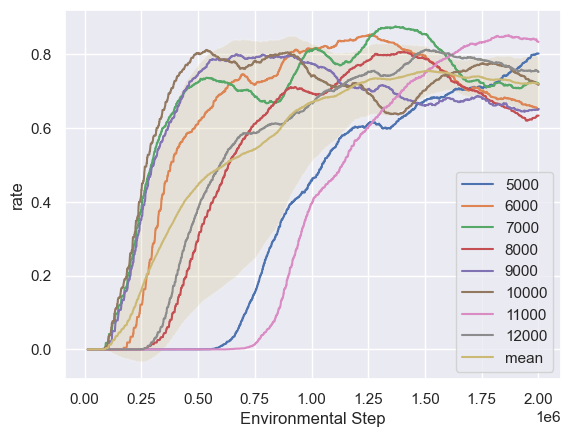

In [5]:
copo_1 = 'exp_CoPO/CoPO_Round_40agents_8workers_2M_8seeds_lr=3e-5[AIBoy]'
copo_2 = 'exp_CoPO/CoPO_Round_40agents_8workers_2M_8seeds_lr=3e-5[Mac]'
copo_3 = 'exp_CoPO/CoPO_Round_40agents_8workers_2M_lr=3e-5[Mac]2'
copo_4 = 'exp_CoPO/CoPO_Round_40agents_8workers_2M_lr=3e-5[Mac]3'

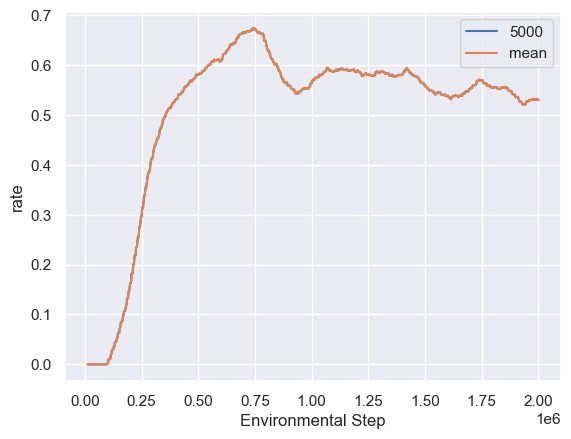

In [15]:

plot_sep_mean('exp_CoPO/CoPO_Round_40agents_8workers_2M_lr=3e-4[Mac]')

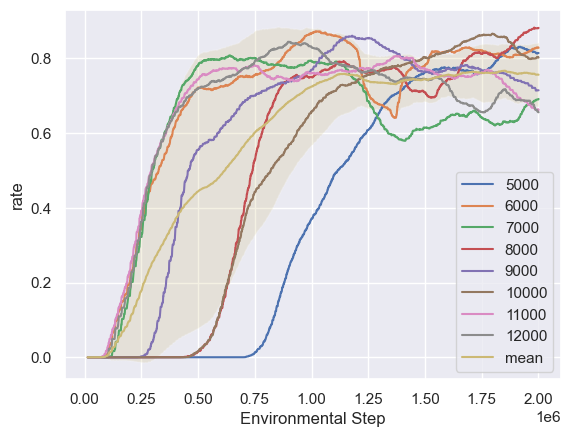

In [12]:
plot_sep_mean(copo_2)

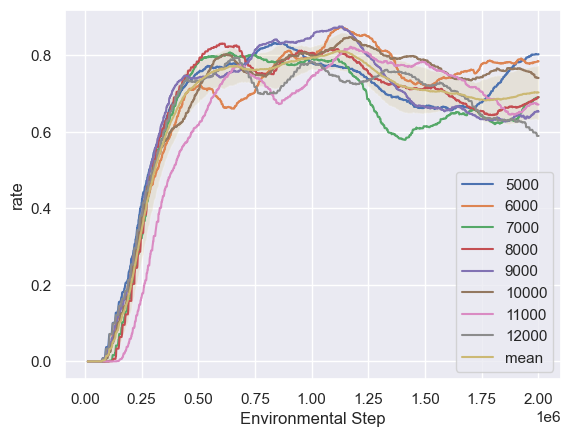

In [13]:
copo_mac2 = 'exp_CoPO/CoPO_Round_40agents_8workers_2M_lr=3e-5[Mac]2'
plot_sep_mean(copo_mac2)

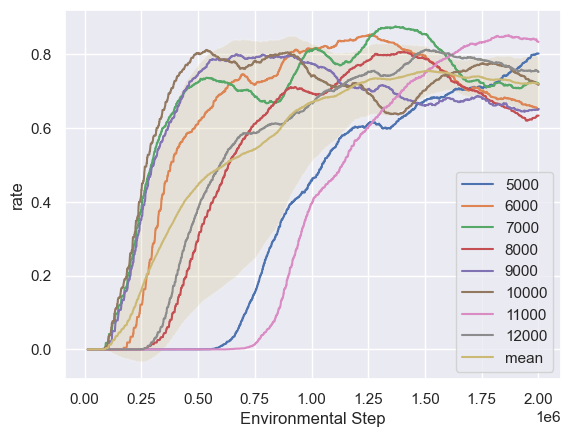

In [14]:

copo_max3 = 'exp_CoPO/CoPO_Round_40agents_8workers_2M_lr=3e-5[Mac]3'
plot_sep_mean(copo_max3)